#### Практическое задание
1. Сформируйте посредством sklearn.make_classification датасет из 100 объектов с двумя признаками. Обучите случайный лес из 1, 3, 10 и 50 деревьев и визуализируйте их разделяющие гиперплоскости на графиках по подобию визуализации деревьев из предыдущего урока, заменив вызов функции predict на tree_vote.
2. Сделайте выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нём.
3. Замените в реализованном алгоритме проверку, используя отложенную выборку на Out-of-Bag.
4. (На повторение) Перепишите функцию calc_gini из урока про решающие деревья так, чтобы в качестве критерия использовалась энтропия Шеннона. Переименуйте функцию в calc_entropy.

In [1597]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import random


from matplotlib.colors import ListedColormap
from sklearn import datasets
from sklearn import model_selection

import numpy as np

Реализуем генерацию $N$ бутстрэп-выборок и подмножества признаков для нахождения разбиения в узле.

In [1598]:
random.seed(42)

def get_bootstrap(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
        bootstrap.append((b_data, b_labels))
        
    return bootstrap

In [1599]:
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = [i for i in range(len_sample)]
    
    len_subsample = int(np.sqrt(len_sample))
    subsample = []
    
    random.shuffle(sample_indexes)
    for _ in range(len_subsample):
        subsample.append(sample_indexes.pop())
        
    return subsample

Повторим реализацию построения дерева решений из предыдущего урока с некоторыми изменениями.

In [1600]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведётся сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [1601]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчёт количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдём класс, количество объектов которого будет максимальным в этом листе, и вернём его    
        prediction = max(classes, key=classes.get)
        return prediction        

In [1602]:
# Расчёт критерия Джини

def gini(labels):
    #  подсчёт количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчёт критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [1603]:
# Расчёт качества

def quality(left_labels, right_labels, current_gini):

    # доля выборки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [1604]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [1605]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample = get_subsample(n_features)
    
    for index in subsample:
        t_values = [row[index] for row in data]
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, где в узле остаётся менее пяти объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [1606]:
# Построение дерева посредством рекурсивной функции

def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай — прекращаем рекурсию, когда нет прироста качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

Теперь добавим функцию формирования случайного леса.

In [1607]:
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    return forest

In [1608]:
# Функция классификации отдельного объекта

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [1609]:
# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [1610]:
# предсказание голосованием деревьев

def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    
    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

Далее сделаем обычное разбиение выборки на обучающую и тестовую, как это делалось ранее. Оценить ошибку этого же алгоритма по методу Out-of-Bag будет вашим практическим заданием к этому уроку.

In [1611]:
# Введём функцию подсчёта точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    
    return correct / float(len(actual)) * 100.0

Теперь построим несколько случайных лесов с разным количеством деревьев в них.

##### 1. Сформируйте посредством sklearn.make_classification датасет из 100 объектов с двумя признаками. Обучите случайный лес из 1, 3, 10 и 50 деревьев и визуализируйте их разделяющие гиперплоскости на графиках по подобию визуализации деревьев из предыдущего урока, заменив вызов функции predict на tree_vote.

In [1612]:
# сгенерируем данные, представляющие собой 500 объектов с пятью признаками
classification_data, classification_labels = datasets.make_classification(n_samples=100,
                                                      n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant=0, random_state=42)

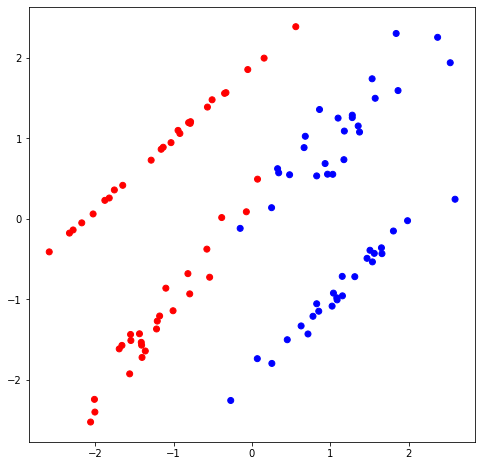

In [1613]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)

In [1614]:
train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [1615]:
# Визуализируем дерево на графике
def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

def show_forest_hyperplane(train_data, train_labels, test_data, test_labels, my_forest, train_accuracy, test_accuracy):
    plt.figure(figsize = (16, 7))

    # график обучающей выборки
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)

    mesh_predictions = np.zeros(xx.shape)

    mesh_predictions += np.array(tree_vote(my_forest, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)

    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)   
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'Train accuracy={train_accuracy:.2f}')

    # график тестовой выборки
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title(f'Test accuracy={test_accuracy:.2f}')
    

Построим лес из одного дерева.

Точность случайного леса из 1 деревьев на обучающей выборке: 94.286
Точность случайного леса из 1 деревьев на тестовой выборке: 90.000


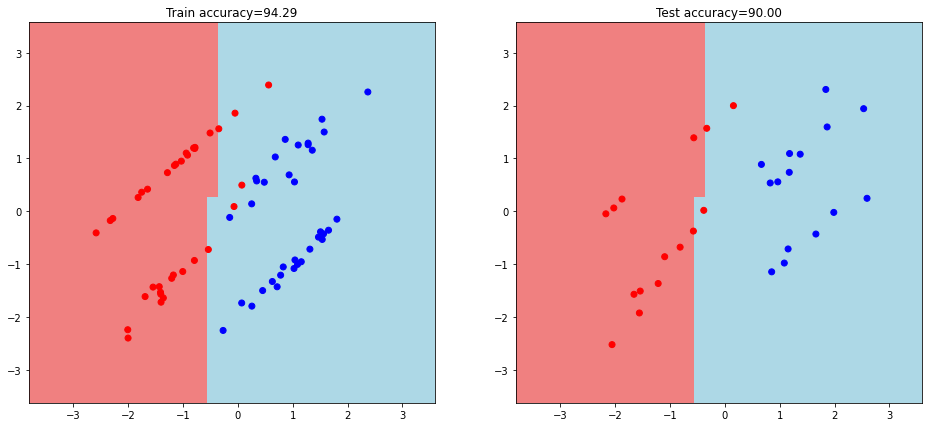

In [1616]:
n_trees = 1
my_forest_1 = random_forest(train_data, train_labels, n_trees)
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_1, train_data)
# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_1, test_data)
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')
show_forest_hyperplane(train_data, train_labels, test_data, test_labels, my_forest_1, train_accuracy, test_accuracy)

Построим лес из трёх деревьев.

Точность случайного леса из 3 деревьев на обучающей выборке: 94.286
Точность случайного леса из 3 деревьев на тестовой выборке: 96.667


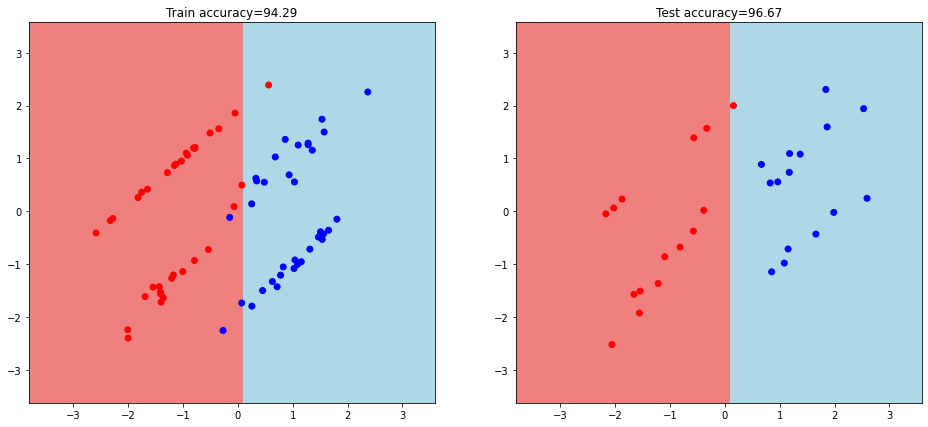

In [1617]:
n_trees = 3
my_forest_3 = random_forest(train_data, train_labels, n_trees)
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_3, train_data)
# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_3, test_data)
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')
show_forest_hyperplane(train_data, train_labels, test_data, test_labels, my_forest_3, train_accuracy, test_accuracy)

Построим лес из десяти деревьев.

Точность случайного леса из 10 деревьев на обучающей выборке: 94.286
Точность случайного леса из 10 деревьев на тестовой выборке: 96.667


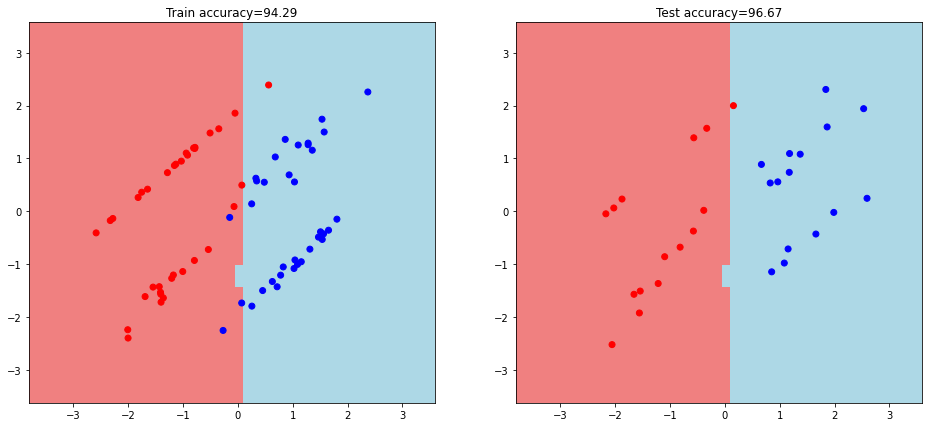

In [1618]:
n_trees = 10
my_forest_10 = random_forest(train_data, train_labels, n_trees)
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_10, train_data)
# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_10, test_data)
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')
show_forest_hyperplane(train_data, train_labels, test_data, test_labels, my_forest_10, train_accuracy, test_accuracy)

Построим лес из пятидесяти деревьев.

Точность случайного леса из 50 деревьев на обучающей выборке: 97.143
Точность случайного леса из 50 деревьев на тестовой выборке: 96.667


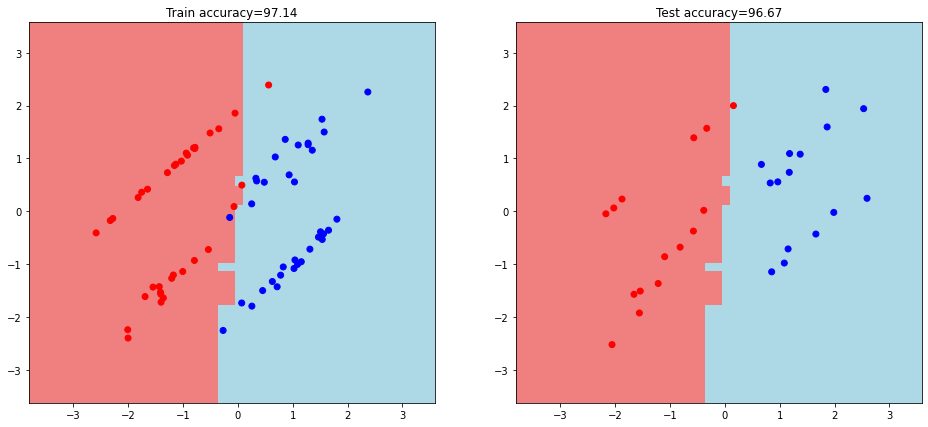

In [1619]:
n_trees = 50
my_forest_50 = random_forest(train_data, train_labels, n_trees)
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_50, train_data)
# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_50, test_data)
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')
show_forest_hyperplane(train_data, train_labels, test_data, test_labels, my_forest_50, train_accuracy, test_accuracy)

##### 2. Сделайте выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нём.

Чем больше деревьев в случайном лесе, тем сложнее получается разделяющая гиперплость, из-за этого появляется переобучение. Чтобы избежать переобучения, нужно подбирать кол-во деревьев в алгоритме случайного леса в качестве гиперпараметра, а качество оценивать на кросс-валидации.

##### 3. Замените в реализованном алгоритме проверку, используя отложенную выборку на Out-of-Bag.


$$OOB = \sum^{l}_{i=1}L\left ( y_{i}, \:\frac{1}{\sum^{N}_{n=1}[x_{i}\notin X_{n}]} \sum^{N}_{n=1}[x_{i} \notin X_{n}]b_{n}(x_{i}) \right ).$$

In [1620]:
def get_bootstrap(data, labels, N, oob_score):
    
    random.seed(42)
    n_samples = data.shape[0]
    bootstrap = []
    oob_data_out = []
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        indicies = []
        
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            indicies.append(sample_index)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
            
        bootstrap.append((b_data, b_labels))
        
        if oob_score:
            oob = [el for el in range(n_samples) if el not in set(indicies)]
            oob_data = data[oob]
            oob_labels = labels[oob]
            oob_data_out.append((oob_data, oob_labels))
        
    return bootstrap, oob_data_out

In [1621]:
def calc_oob_acc(oob_examples, tree):
    oob_answers = predict(oob_examples[0], tree)
    oob_acc = accuracy_metric(oob_examples[1], oob_answers)
    return oob_acc
n_trees = 50

In [1622]:
def random_forest(data, labels, n_trees, oob_score=False):
    forest = []
    bootstrap, oob_examples = get_bootstrap(data, labels, n_trees, oob_score=oob_score)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    if oob_score:
        oob_acc = 0
        for i in range(n_trees):
            oob_acc += calc_oob_acc(oob_examples[i], forest[i])
        
        oob_acc = oob_acc / n_trees
        return forest, oob_acc
    
    return forest

In [1623]:
my_forest_50, oob_score = random_forest(train_data, train_labels, n_trees, oob_score=True)

print(f'OOB Score: {oob_score:.3f}')

OOB Score: 84.190


##### 4. (На повторение) Перепишите функцию calc_gini из урока про решающие деревья так, чтобы в качестве критерия использовалась энтропия Шеннона. Переименуйте функцию в calc_entropy.

In [1624]:
# энтропия Шеннона

def calc_entropy(labels):
    #  подсчёт количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчёт критерия
    # impurity = sum([-val/len(labels) * np.log2(val/len(labels)) for _, val in classes.items()])
    impurity = 0
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p * np.log2(p)
        
    return impurity

In [1625]:
# Расчёт качества

def quality(left_labels, right_labels, current_entropy):

    # доля выборки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_entropy - p * calc_entropy(left_labels) - (1 - p) * calc_entropy(right_labels)

In [1626]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5

    current_entropy = calc_entropy(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample = get_subsample(n_features)
    
    for index in subsample:
        t_values = [row[index] for row in data]
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, где в узле остаётся менее пяти объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_entropy)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [1627]:
n_trees = 3
my_forest_3 = random_forest(train_data, train_labels, n_trees)
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_3, train_data)
# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_3, test_data)
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 3 деревьев на обучающей выборке: 94.286
Точность случайного леса из 3 деревьев на тестовой выборке: 93.333


In [1628]:
calc_entropy([1,1,1,0,0,0,0,0,0,0])

0.8812908992306927

In [1629]:
gini([1,1,1,0,0,0,0,0,0,0])

0.4200000000000001